In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
POS_path = os.path.join('data','positive')
NEG_path = os.path.join('data','negitive')
ANC_path = os.path.join('data','anchor')

In [6]:
os.makedirs(POS_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
os.makedirs(NEG_path)
os.makedirs(ANC_path)

In [ ]:
!tar -xf lfw.tgz

In [5]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_path, file)
        os.replace(EX_PATH, NEW_PATH)

In [6]:

# Import uuid library to generate unique image names
import uuid

os.path.join(ANC_path, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\ece9ba3a-e3a0-11ee-93c7-8c37807e9941.jpg'

In [7]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_path, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_path, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [7]:
anchor = tf.data.Dataset.list_files(ANC_path+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_path+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_path+'\*.jpg').take(300)

In [8]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    return img

In [9]:

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data\\anchor\\93dab80c-e2cf-11ee-a091-8d6dde08bf9d.jpg',
 b'data\\positive\\efe10656-e2cf-11ee-8f5a-8d6dde08bf9d.jpg',
 1.0)

In [11]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [12]:
res = preprocess_twin(*exampple)

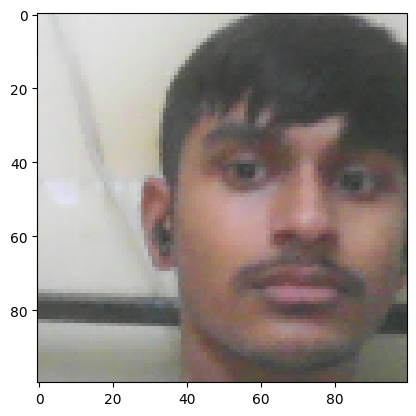

In [13]:
plt.imshow(res[1])

In [14]:
res[2]

1.0

In [15]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [16]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [17]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [18]:
inp = Input(shape=(100,100,3),name='input_image')

In [19]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)
m1=MaxPooling2D(64,(2,2),padding='same')(c1)

In [20]:
c2 = Conv2D(128,(7,7),activation='relu')(m1)
m2=MaxPooling2D(64,(2,2),padding='same')(c2)

In [21]:
c3 = Conv2D(128,(4,4),activation='relu')(m2)
m3=MaxPooling2D(64,(2,2),padding='same')(c3)

In [22]:
c4 = Conv2D(256,(4,4),activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation = 'sigmoid')(f1)

In [23]:
mod = Model(inputs = [inp],outputs=[d1],name='embedding')

In [24]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [25]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    return Model(inputs = [inp],outputs=[d1],name= 'embedding')

In [26]:
embedding = make_embedding()

In [27]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [28]:
class l1dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [29]:
l1 = l1dist()

In [30]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [31]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [32]:
siamese_layer = l1dist()

In [33]:
distances = siamese_layer(inp_embedding,val_embedding)

In [34]:
classifier = Dense(1,activation = 'sigmoid')(distances)

In [35]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [36]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [37]:

siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [38]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = l1dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [39]:
siamese_model = make_siamese_model()

In [40]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [41]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [42]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [44]:
test_batch = train_data.as_numpy_iterator()

In [45]:
batch_1 = test_batch.next()

In [46]:
len(batch_1)

3

In [47]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [72]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [49]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 103s 4s/step

 Epoch 2/50
27/27 [==============================] - 69s 3s/step

 Epoch 3/50
27/27 [==============================] - 57s 2s/step

 Epoch 4/50
27/27 [==============================] - 60s 2s/step

 Epoch 5/50
27/27 [==============================] - 87s 3s/step

 Epoch 6/50
27/27 [==============================] - 105s 4s/step

 Epoch 7/50
27/27 [==============================] - 105s 4s/step

 Epoch 8/50
27/27 [==============================] - 107s 4s/step

 Epoch 9/50
27/27 [==============================] - 108s 4s/step

 Epoch 10/50
27/27 [==============================] - 107s 4s/step

 Epoch 11/50
27/27 [==============================] - 106s 4s/step

 Epoch 12/50
27/27 [==============================] - 105s 4s/step

 Epoch 13/50
27/27 [======================

In [50]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [51]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [52]:

# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 3s 3s/step


array([[1.0000000e+00],
       [5.8329604e-12],
       [6.1574357e-13],
       [1.0000000e+00],
       [7.7738911e-13],
       [1.0000000e+00],
       [9.9999923e-01],
       [1.0000000e+00],
       [9.9999619e-01],
       [4.0535596e-11],
       [4.5568021e-14],
       [7.7576019e-12],
       [4.9281695e-10],
       [2.0098148e-10],
       [1.9079616e-09],
       [9.9997663e-01]], dtype=float32)

In [53]:

# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]

In [54]:

y_true

array([1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [55]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [56]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

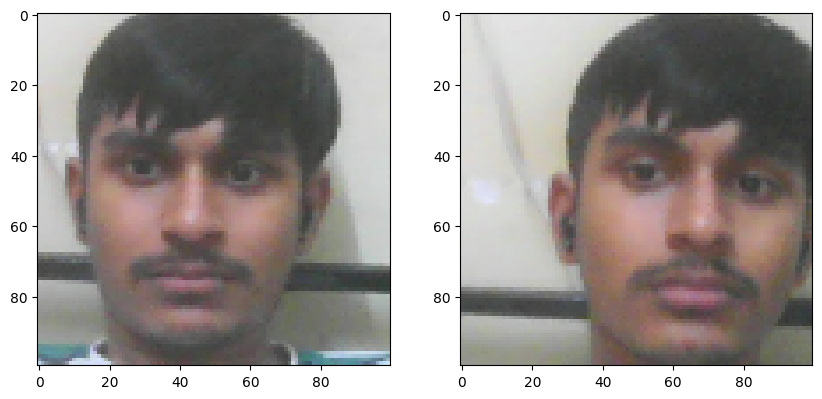

In [57]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [58]:
# Save weights
siamese_model.save('siamesemodel.h5')

c:\Users\Shubham Garg\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
l1dist

__main__.l1dist

In [60]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'l1dist':l1dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [61]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 4s 4s/step


array([[1.0000000e+00],
       [5.8329604e-12],
       [6.1574357e-13],
       [1.0000000e+00],
       [7.7738911e-13],
       [1.0000000e+00],
       [9.9999923e-01],
       [1.0000000e+00],
       [9.9999619e-01],
       [4.0535596e-11],
       [4.5568021e-14],
       [7.7576019e-12],
       [4.9281695e-10],
       [2.0098148e-10],
       [1.9079616e-09],
       [9.9997663e-01]], dtype=float32)

In [62]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [67]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [73]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 98ms/step
False
1/1 [==============================] - 0s 95ms/step
True
1/1 [==============================] - 0s 99ms/step
False
1/1 [==============================] - 0s 103ms/step
True
